# S4E4 - Abalone Ring Prediction EDA

Predict abalone rings given physical features

* Initial EDA and baseline linear regression model

# Installs

In [50]:
!pip install scienceplots

## Imports

In [51]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# optional if pip install scienceplots
import scienceplots
plt.style.use(['science','no-latex'])

## Read Data

In [52]:
root_dir = '/kaggle/input/playground-series-s4e4'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

## Top Level EDA

In [53]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


Test Data Shape: (60411, 9)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Sample Submission Shape: (60411, 2)


,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [54]:
def df_info(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

df_info(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,90615,90615
Sex,object,0,0.000000,3,90615
Length,float64,0,0.000000,157,90615
Diameter,float64,0,0.000000,126,90615
Height,float64,0,0.000000,90,90615
Whole weight,float64,0,0.000000,3175,90615
Whole weight.1,float64,0,0.000000,1799,90615
Whole weight.2,float64,0,0.000000,979,90615
Shell weight,float64,0,0.000000,1129,90615
Rings,int64,0,0.000000,28,90615


### Takeaways
* Target = Rings
    * Datatype: int64 with cardinality of 28
* Decent size: train = 91K records, test = 60K records
* 8 Features + 'id'
* All features float except sex which is object (convert to categorial)
    * Some have low value counts (height has 90)
* No missing data to impute


## EDA - Univariate Distributions

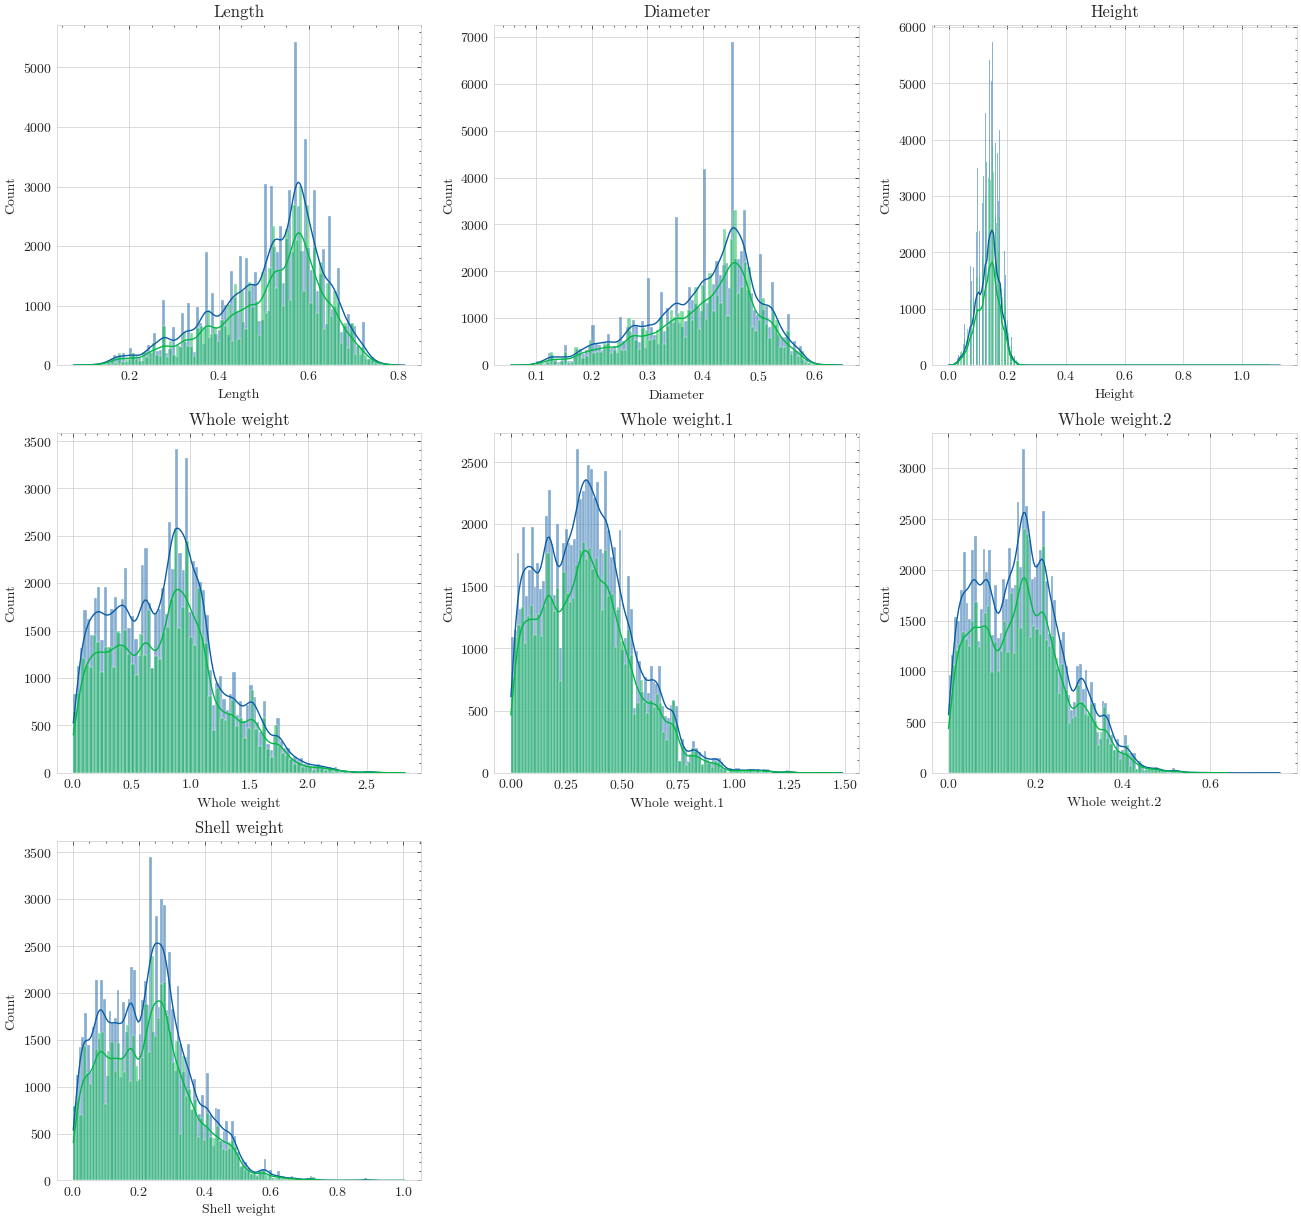

In [55]:
features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)

### Takeaways
* Some skewed, try scaling/transforming

## Categorical Distributions
* The only categorical is sex
    * I = immature 

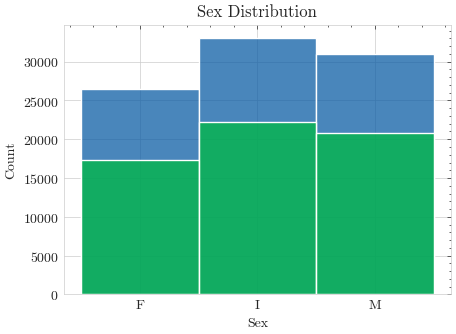

In [71]:
plt.figure(figsize=(5,3.5))
sns.histplot(train['Sex'])
sns.histplot(test['Sex'])
plt.title('Sex Distribution')
plt.show()

## Target Distribution

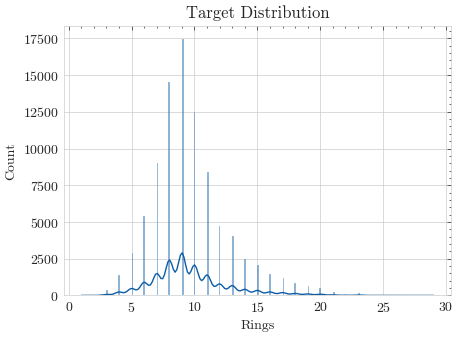

In [57]:
plt.figure(figsize=(5,3.5))
sns.histplot(train['Rings'],kde=True)
plt.title('Target Distribution')
plt.show()

## Correlations

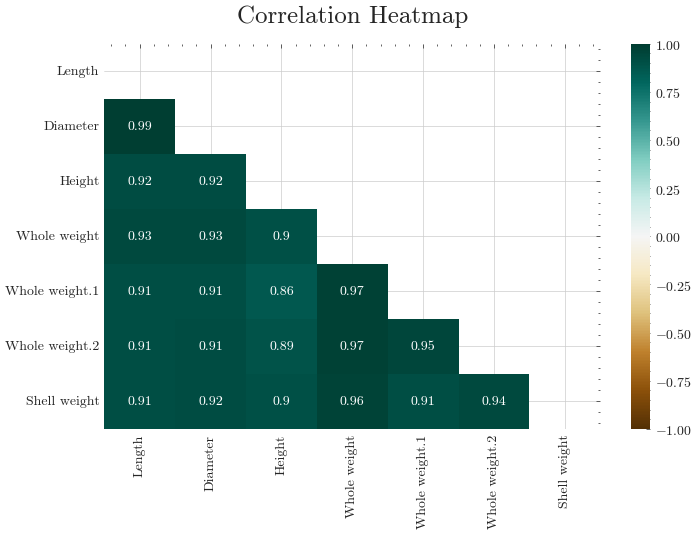

In [58]:
plt.figure(figsize=(8, 5)) 
mask = np.triu(np.ones_like(train[features].corr(),dtype=bool)) 
heatmap = sns.heatmap(train[features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

### Takeaways
* super high correlations in this data
* maybe PCA

## Correlation with Target

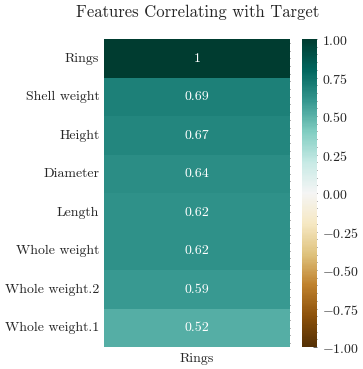

In [59]:
# add target to features
features = [col for col in train.columns if train[col].dtype=='float']
features_corr = features.copy()
features_corr.append('Rings')

plt.figure(figsize=(3, 4)) # set size by num of features 
heatmap = sns.heatmap(train[features_corr].corr()[['Rings']].sort_values(by='Rings', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':12}, pad=16);

## Preprocessing/Cleaning
* No imputation necessary
* convert sex to categorical


In [60]:
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')



## Feature Engineering
* None for first baseline
* later look at:
    * adding features
    * scaling/transforming

## Split Data
* Baseline is simple split with float features only
* Later n-fold cross validation

In [61]:
from sklearn.model_selection import train_test_split

target = train['Rings']
target_log = np.log1p(target)
y = target_log

X_train, X_val, y_train, y_val = train_test_split(train[features], y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

X_test = test[features]


## Models
* metric = root mean squared log error
* This is only in v1.4, kaggle uses 1.2,2,  so could install newer version or take log of RMSE manually instead...
* Going the manual route
    * make sure to take exponential before submission
   

In [62]:
# !pip uninstall -y sklearn
# !conda install -y scikit-learn=1.4.1.post1


In [63]:
# from sklearn.metrics import root_mean_squared_log_error  # only in v 1.4
from sklearn.metrics import mean_squared_error

## Baseline Model - Linear Regression
* Start with default linear regression on floats only

In [70]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train) 

pred_lr = model_lr.predict(X_val)

score_lr = mean_squared_error(y_val, pred_lr,squared=False)
print(f'Linear Regression RMSLE: {score_lr}')

Linear Regression RMSLE: 0.16836907459871167


## Predictions on Test

In [65]:
preds = model_lr.predict(X_test)
preds[0:10]

array([2.28002868, 2.38226118, 2.38260487, 2.47691716, 2.16959176,
       2.34239534, 2.6219612 , 1.98496453, 2.20572245, 2.51131396])

In [66]:
preds = np.expm1(preds)

In [67]:
np.min(preds)

2.8107851257042804

## Submission

In [68]:
ss.Rings = preds
ss.head()

,id,Rings
0,90615,8.776961
1,90616,9.829362
2,90617,9.833085
3,90618,10.904508
4,90619,7.754709


In [69]:
ss.to_csv('submission.csv',index=False)